In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import zipfile
import pandas as pd
import numpy as np
import datetime
import xml.etree.ElementTree as ET
from sklearn.preprocessing import StandardScaler
from sklearn.svm import OneClassSVM
from sklearn.linear_model import LinearRegression
import os
import matplotlib.pyplot as plt


In [3]:
# Specify the path to the ZIP file
zip_file_path = '/content/drive/MyDrive/OhioT1DM.zip'

# Specify the directory to extract the contents of the ZIP file
extract_dir = "/content/drive/MyDrive/OhioT1DM"

# Password for encrypted files if applicable
password = "...@@@!!==/\/\/\/\~~~~~BGLP-1804-BGLP~~~~~/\/\/\/\==!!@@@..."

# Create the extraction directory if it doesn't exist
os.makedirs(extract_dir, exist_ok=True)

# Extract the contents of the ZIP file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    for member in zip_ref.infolist():
        # Check if the file is encrypted
        if member.flag_bits & 0x01:
            zip_ref.extract(member, extract_dir, pwd=password.encode())
        else:
            zip_ref.extract(member, extract_dir)

print("Extraction completed successfully.")


Extraction completed successfully.


In [4]:
# code for reading the xml files is influenced/copied by https://github.com/r-cui/GluPred/blob/master/preprocess/loader.py

# this function extracts the glucose data from the xml files (features are the glucose value and the time)
# then the data is rounded and resampled to 5 minutes
# rounding can cause duplicates as to why only the first value is kept
# resampling is needed to create a uniform time sequence and identify gaps
def get_glc(root):
    glucose = []
    glucose_ts = []
    for type_tag in root.findall('glucose_level/event'):
        value = type_tag.get('value')
        ts = type_tag.get('ts')
        ts = datetime.datetime.strptime(ts, "%d-%m-%Y %H:%M:%S")
        glucose.append(int(value))
        glucose_ts.append(ts)

    glc_frame = [glucose_ts, glucose]
    glc_frame = np.array(glc_frame)
    df_glc = pd.DataFrame(glc_frame.T, columns=['ts', 'glucose'])
    df_glc["ts"] = df_glc["ts"].dt.round('5min')
    df_glc["ts"] = df_glc["ts"].drop_duplicates()

    df_glc = df_glc.set_index('ts')
    df_glc = df_glc.resample("5min").asfreq()
    df_glc = df_glc.reset_index()

    return df_glc


# Function to extract meal data from XML
def get_meal(root):
    carbs = []
    meal_ts = []
    for type_tag in root.findall('meal/event'):
        value = type_tag.get('carbs')
        ts = type_tag.get('ts')
        ts = datetime.datetime.strptime(ts, "%d-%m-%Y %H:%M:%S")
        carbs.append(float(value))
        meal_ts.append(ts)

    meal_frame = [meal_ts, carbs]
    meal_frame = np.array(meal_frame)
    df_meal = pd.DataFrame(meal_frame.T, columns=['ts', 'carbs'])

    # Round the timestamp to 5-minute intervals
    df_meal['ts'] = pd.to_datetime(df_meal['ts'])
    df_meal = df_meal.set_index('ts').resample('5min').ffill().reset_index()

    return df_meal

# this function extracts the basal insulin from the xml file which consists of the attributs: basal, temp_basal, and bolus
# basal and temp_basal need to be combined and the original basal value is replaced wtih temp_basal
# furthermore, basal is resampled to 5 minutes and the missing values are filled with the prior values
# as basal is applied continously, it only changes when a new basal rate is set

def get_basal(root):
    basal = []
    basal_ts = []

    for type_tag in root.findall('basal/event'):
        value = type_tag.get('value')
        ts = type_tag.get('ts')
        ts = datetime.datetime.strptime(ts, "%d-%m-%Y %H:%M:%S")
        basal.append(float(value))
        basal_ts.append(ts)

    basal_frame = [basal_ts, basal]
    basal_frame = np.array(basal_frame)
    df_basal = pd.DataFrame(basal_frame.T, columns=['ts', 'basal'])

    df_basal["ts"] = pd.to_datetime(df_basal["ts"])

    df_basal = df_basal.set_index('ts')
    df_basal = df_basal.resample("5min").ffill()
    df_basal = df_basal.reset_index()

    return df_basal


# temp_basal is a temporary dosage replacing the original basal rate, with a value of 0 the basal rate is suspended

def get_temp_basal(root):
    temp_basal = []
    temp_basal_ts = []
    temp_basal_dur = []

    for type_tag in root.findall('temp_basal/event'):
        value = type_tag.get('value')
        ts = type_tag.get('ts_begin')
        ts_end = type_tag.get('ts_end')
        ts = datetime.datetime.strptime(ts, "%d-%m-%Y %H:%M:%S")
        ts_end = datetime.datetime.strptime(ts_end, "%d-%m-%Y %H:%M:%S")
        temp_basal_dur.append(ts_end)
        temp_basal.append(float(value))
        temp_basal_ts.append(ts)

    temp_basal_frame = [temp_basal_ts, temp_basal, temp_basal_dur]
    temp_basal_frame = np.array(temp_basal_frame)
    df_temp_basal = pd.DataFrame(temp_basal_frame.T, columns=['ts', 'temp_basal', 'basal_end'])

    df_temp_basal["ts"] = pd.to_datetime(df_temp_basal["ts"] )
    df_temp_basal["basal_end"] = pd.to_datetime(df_temp_basal["basal_end"])

    # the data is rounded to 5 minutes
    df_temp_basal["ts"] = df_temp_basal["ts"].dt.round('5min')
    df_temp_basal["basal_end"] = df_temp_basal["basal_end"].dt.round('5min')
    return df_temp_basal


# This function aims to replace temp basal with the basal value, by identifying the start and end time of
# temporal basal infusion

def combine_basal_temp_basal(df_b, df_temp_b):

    # first the basal dataframe and the dataframe with the temporal basal information are merged with a left join
    # thus all time intervals in which no temporal basal was infused gets a nan value
    # this enables to check for all instances without nan values to identify the basal dosage which needs to be replaced
    combined_df = pd.merge(df_b, df_temp_b, on='ts', how='left')
    combined_df["temp_basal"] = combined_df["temp_basal"].fillna(-1)

    for i in range (0, len(combined_df)):
        # condition to identify only the location of the basal rates which overlap with a temporal basal dosage
        if((combined_df["temp_basal"][i]  != -1)):
            start_time = combined_df["ts"][i]
            end_time = combined_df["basal_end"][i]
            # after identifying the start and end, the values are replaced with the temporal dosage
            combined_df.loc[(combined_df["ts"] >= start_time) & (combined_df["ts"] <= end_time), "basal"] = combined_df["temp_basal"][i]

    combined_df = combined_df.drop("basal_end", axis=1)
    combined_df = combined_df.drop("temp_basal", axis=1)
    # the new dataframe is returned
    return combined_df


# this function extracts the data of bolus insulin from the xml file
# bolus insulin is not infused continously, thus the start and endtime need to be identified to set the
# correct bolus for each infusion duration in the later steps
# the function returns a dataframe with the time, the bolus insulin dosage and the end time of infusion

def get_bolus(root):
    bolus = []
    bolus_ts = []
    bolus_end = []

    for type_tag in root.findall('bolus/event'):
        value = type_tag.get('dose')
        ts = type_tag.get('ts_begin')
        ts = datetime.datetime.strptime(ts, "%d-%m-%Y %H:%M:%S")
        ts_end = type_tag.get('ts_end')
        ts_end = datetime.datetime.strptime(ts_end, "%d-%m-%Y %H:%M:%S")
        bolus_ts.append(ts)
        bolus_end.append(ts_end)
        bolus.append(float(value))

    bolus_frame = [bolus_ts, bolus, bolus_end]
    bolus_frame = np.array(bolus_frame)
    df_bolus =pd.DataFrame(bolus_frame.T, columns=['ts', 'bolus', 'bolus_end'])

    # the data is rounded to 5 minutes
    df_bolus['ts'] = df_bolus['ts'].dt.round('5min')
    df_bolus["ts"] = df_bolus["ts"].drop_duplicates()

    # the data is rounded to 5 minutes
    df_bolus['bolus_end'] = df_bolus['bolus_end'].dt.round('5min')
    df_bolus['bolus_end'] = df_bolus['bolus_end'].drop_duplicates()

    return df_bolus


# this function extarcts the exercise data from the xml file for the 2018 cohort
# The problem with the exercise data is that both patient cohorts use different wearables and parameters, hence to have
# uniform data, the step count is converted to the magnitude of acceleration while the data in the 2020 cohort is kept as it is

def get_step(root):
    steps = []
    steps_ts = []
    for type_tag in root.findall('basis_steps/event'):
        value = type_tag.get('value')
        ts = type_tag.get('ts')
        ts = datetime.datetime.strptime(ts, "%d-%m-%Y %H:%M:%S")
        steps.append(int(value))
        steps_ts.append(ts)

    steps_frame = [steps_ts, steps]
    steps_frame = np.array(steps_frame)
    df_steps = pd.DataFrame(steps_frame.T, columns=['ts', 'steps'])

    # the data is rounded to 5 minutes
    df_steps['ts'] = df_steps['ts'].dt.round('5min')
    df_steps['ts'] = df_steps['ts'].drop_duplicates()

    # self reported sleep data is read to compensate for possible missing values during the night
    df_sleep = get_sleep(root)
    # step count values are replaced with 0 if the subject sleeps
    combined_df = combine_step_sleep(df_steps, df_sleep)
    # step count is converted to magnitude of acceleration
    df_macc = convert_step_to_MOA(combined_df)

    return df_macc


# the step count could have missing values as to why the sleep time information is extracted to include 0 activity while sleeping
# this functions extracts the reported time intervals of sleep and returns a dataframe with start and end time

def get_sleep(root):
    sleep_start = []
    sleep_end = []
    for type_tag in root.findall('sleep/event'):
        start = type_tag.get('ts_end')
        end = type_tag.get('ts_begin')
        start = datetime.datetime.strptime(start, "%d-%m-%Y %H:%M:%S")
        end = datetime.datetime.strptime(end, "%d-%m-%Y %H:%M:%S")
        sleep_start.append(start)
        sleep_end.append(end)

    sleep_frame = [sleep_start, sleep_end]
    sleep_frame = np.array(sleep_frame)
    df_sleep = pd.DataFrame(sleep_frame.T, columns=['ts', 'sleep_end'])

    # the data is rounded to 5 minutes
    df_sleep['ts'] = df_sleep['ts'].dt.round('5min')
    df_sleep['sleep_end'] = df_sleep['sleep_end'].dt.round('5min')

    return df_sleep


# this function merges the step count with the reported sleep intervals and replaces the values with 0 if the person was sleeping

def combine_step_sleep(df_step, df_sleep):


    combined_df = pd.merge(df_step, df_sleep, on='ts', how='left')
    combined_df["steps"] = combined_df["steps"].fillna(-1)

    for i in range (0, len(combined_df)):
        if((combined_df["steps"][i]  != -1)):
            start_time = combined_df["ts"][i]
            end_time = combined_df["sleep_end"][i]
            # condition is checked and values are replaced
            combined_df.loc[(combined_df["ts"] >= start_time) & (combined_df["sleep_end"] <= end_time), "steps"] = 0

    combined_df = combined_df.drop("sleep_end", axis=1)

    return combined_df


'''
formulas are taken from:
https://www.omnicalculator.com/physics/velocity : velocity
https://www.omnicalculator.com/physics/magnitude-of-acceleration : acceleration and magnitude of acceleration

- The formula for the magnitude of acceleration is the absolute value of the acceleration with a formula of |a| = sqrt(pow(x))
- x in this case is the acceleration computed by the change in velocity divided by the time interval
- so for converting step count into the magnitude of acceleration, the first step is to compute the velocity from the distance divided by the needed time
- velocity = distance/time
- acc = change in velocity/ change in time
- moacc = |a| = sqrt(pow(x)) -> the absolute value was not taken since the 2020 also indicate negative acceleration

1. First, the step count is converted to a distance of meters. Here, according to research the standard equality is 1 step = 0.74 - 0.76 meters.
    -> velocity = (step count * 0.75) / (5)
2. Secondly, the acceleration is calcualted from subtracting the considered velocity from the previous velocity (initial) and divide it again by (5)
'''

def convert_step_to_MOA(df_steps):
    time_interval = 5

    df_steps['steps'] = df_steps['steps'].mul(0.75)
    df_steps['velocity'] = df_steps['steps'].div(time_interval)
    df_steps.loc[(df_steps["steps"] == 0), "velocity"] = 0.0
    df_steps['prior_velocity'] = df_steps['velocity'].shift(1, axis=0)
    df_steps['difference'] = df_steps['velocity'] - df_steps['prior_velocity']
    df_steps['acc'] = df_steps['difference'].div(time_interval)
    df_steps['macc'] = df_steps['acc']

    # here if the actual and prior velocity are 0 the value is set to 0 as well to not cause infinitiy values irritating the computation
    df_steps.loc[(df_steps["velocity"] == 0) & (df_steps["prior_velocity"] == 0) , "macc"] = 0.0

    df_macc = df_steps[['ts', 'macc']]

    # scale the data to 0 and 1
    df_min_max_scaled = df_macc.copy()
    df_min_max_scaled ['macc'] = (df_min_max_scaled['macc'] - df_min_max_scaled['macc'].min()) / (df_min_max_scaled['macc'].max() - df_min_max_scaled['macc'].min())

    # the converted dataframe is returned
    return df_min_max_scaled



# this function extracts the acceleration data for the 2020 cohort from the xml file

def get_macc(root):

    macc = []
    macc_ts = []

    for type_tag in root.findall('acceleration/event'):
        value = type_tag.get('value')
        ts = type_tag.get('ts')
        ts = datetime.datetime.strptime(ts, "%d-%m-%Y %H:%M:%S")
        macc.append(float(value))
        macc_ts.append(ts)
    macc_frame = [macc_ts, macc]
    macc_frame = np.array(macc_frame)
    df_macc = pd.DataFrame(macc_frame.T, columns=['ts', 'macc'])

    # it is resampled to 5 minutes and sum the magnitude of the single minutes, so that every 5 minutes the MoA summed over 5 minutes is presented
    # since the acceleration is reported in one minute intervals
    df_macc = df_macc.set_index('ts')
    df_macc = df_macc.resample("5min").sum()
    df_macc = df_macc.reset_index()
    # 0.0 possibly meant missing values
    df_macc = df_macc.replace(0.0, np.nan)

    # scale the data to 0 and 1
    df_min_max_scaled = df_macc.copy()
    df_min_max_scaled ['macc'] = (df_min_max_scaled['macc'] - df_min_max_scaled['macc'].min()) / (df_min_max_scaled['macc'].max() - df_min_max_scaled['macc'].min())

    return df_min_max_scaled

In [5]:
def load_data(train_file, test_file, subject_id, version):
    try:
        print(f"Loading data for subject {subject_id}...")
        print(f"Train file path: {train_file}")
        print(f"Test file path: {test_file}")

        if not os.path.isfile(train_file):
            raise FileNotFoundError(f"Train file {train_file} does not exist.")
        if not os.path.isfile(test_file):
            raise FileNotFoundError(f"Test file {test_file} does not exist.")

        # Parse the train and test XML files
        train_root = ET.parse(train_file).getroot()
        test_root = ET.parse(test_file).getroot()

        # Extract data from train and test XML
        df_glc_train = get_glc(train_root)
        df_basal_train = get_basal(train_root)
        df_bolus_train = get_bolus(train_root)
        df_meal_train = get_meal(train_root)
        df_macc_train = get_macc(train_root)

        df_glc_test = get_glc(test_root)
        df_basal_test = get_basal(test_root)
        df_bolus_test = get_bolus(test_root)
        df_meal_test = get_meal(test_root)
        df_macc_test = get_macc(test_root)

        # Combine train data
        train_data = pd.merge(df_glc_train, df_basal_train, on='ts', how='left')
        train_data = pd.merge(train_data, df_bolus_train, on='ts', how='left')
        train_data = pd.merge(train_data, df_meal_train, on='ts', how='left')
        train_data = pd.merge(train_data, df_macc_train, on='ts', how='left')

        # Combine test data
        test_data = pd.merge(df_glc_test, df_basal_test, on='ts', how='left')
        test_data = pd.merge(test_data, df_bolus_test, on='ts', how='left')
        test_data = pd.merge(test_data, df_meal_test, on='ts', how='left')
        test_data = pd.merge(test_data, df_macc_test, on='ts', how='left')

        # Concatenate train and test data
        combined_df = pd.concat([train_data, test_data])

        # Fill missing values
        combined_df['basal'] = combined_df['basal'].fillna(method='ffill').fillna(method='bfill')
        combined_df['bolus'] = combined_df['bolus'].fillna(0)
        combined_df['carbs'] = combined_df['carbs'].fillna(0)
        combined_df['macc'] = combined_df['macc'].fillna(-1)

        print(f"Successfully loaded and combined data for subject {subject_id}")
        return combined_df

    except FileNotFoundError as fnf_error:
        print(fnf_error)
    except ET.ParseError as parse_error:
        print(f"Error parsing XML file: {parse_error}")
    except Exception as e:
        print(f"An unexpected error occurred while loading data for subject {subject_id}: {e}")
    return None

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, silhouette_score
from sklearn.model_selection import train_test_split, GridSearchCV

def apply_one_class_svm(df_local):
    # Check if the input DataFrame is None or empty
    if df_local is None or df_local.empty:
        raise ValueError("Input DataFrame is None or empty. Please pass a valid DataFrame.")

    # Filter normal data (glucose > 70) for training the One-Class SVM
    normal_data = df_local[df_local['glucose'] > 70]

    # Debugging: Check if there are any normal glucose values
    print(f"Number of normal glucose values (> 70): {len(normal_data)}")
    if normal_data.empty:
        raise ValueError("No normal glucose data available for training (glucose > 70).")

    # Extract relevant features for training (glucose, carbs, basal, bolus, macc)
    X_train = normal_data[['glucose', 'carbs', 'basal', 'bolus', 'macc']].fillna(0)

    # Scale the features using StandardScaler
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)

    # Define and train the One-Class SVM model
    svm = OneClassSVM(kernel='rbf', gamma='auto', nu=0.05)
    svm.fit(X_train_scaled)

    # Apply the model to the entire DataFrame (including glucose =< 70)
    X_all = df_local[['glucose', 'carbs', 'basal', 'bolus', 'macc']].fillna(0)
    X_all_scaled = scaler.transform(X_all)

    # Predict anomalies (hypoglycemia as anomalies)
    df_local.loc[:, 'anomaly'] = svm.predict(X_all_scaled)

    # Debugging: Check if anomalies are being predicted
    print(f"Subject has {len(df_local)} data points, anomalies predicted: {sum(df_local['anomaly'] == -1)}")

    # Convert SVM output (-1 for anomaly, 1 for normal) to 1 for anomaly, 0 for normal
    df_local.loc[:, 'anomaly'] = df_local['anomaly'].apply(lambda x: 1 if x == -1 else 0)

    # Return the updated DataFrame with anomaly labels
    return df_local


In [14]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, silhouette_score, make_scorer
from sklearn.model_selection import train_test_split, GridSearchCV



def apply_one_class_svm(df_local):
    # Check if the input DataFrame is None or empty
    if df_local is None or df_local.empty:
        raise ValueError("Input DataFrame is None or empty. Please pass a valid DataFrame.")

    # Step 1: Handle missing values
    df_local = df_local.fillna(method='ffill').fillna(method='bfill')

    # Step 2: Check for constant values
    for feature in ['carbs', 'basal', 'bolus', 'macc']:
        if df_local[feature].nunique() == 1:
            print(f"Feature {feature} has constant values. CCC may return nan.")

    # Filter normal data (glucose >= 70) for training the One-Class SVM
    normal_data = df_local[df_local['glucose'] > 70]

    print(f"Number of normal glucose values (>= 70): {len(normal_data)}")
    if normal_data.empty:
        raise ValueError("No normal glucose data available for training (glucose >= 70).")

    # Extract relevant features for training (glucose, carbs, basal, bolus, macc)
    X_train = normal_data[['glucose', 'carbs', 'basal', 'bolus', 'macc']].fillna(0)

    # Scale the features using StandardScaler
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)

    # Define and train the One-Class SVM model
    svm = OneClassSVM(kernel='rbf', gamma='auto', nu=0.05)
    svm.fit(X_train_scaled)

    # Apply the model to the entire DataFrame (including glucose < 70)
    X_all = df_local[['glucose', 'carbs', 'basal', 'bolus', 'macc']].fillna(0)
    X_all_scaled = scaler.transform(X_all)

    # Predict anomalies (hypoglycemia as anomalies)
    df_local['anomaly'] = svm.predict(X_all_scaled)

    print(f"Subject has {len(df_local)} data points, anomalies predicted: {sum(df_local['anomaly'] == -1)}")

    # Convert SVM output (-1 for anomaly, 1 for normal) to 1 for anomaly, 0 for normal
    df_local['anomaly'] = df_local['anomaly'].apply(lambda x: 1 if x == -1 else 0)

    return df_local

In [20]:
# Visualize anomalies in glucose levels
def plot_anomalies(df, subject_id):
    plt.figure(figsize=(10, 6))
    plt.plot(df['ts'], df['glucose'], label='Glucose Levels')
    anomalies = df[df['anomaly'] == 1]
    plt.scatter(anomalies['ts'], anomalies['glucose'], color='red', label='Anomalies (glucose <= 70)')
    plt.title(f'Subject {subject_id}: Glucose Levels with Anomalies')
    plt.xlabel('Timestamp')
    plt.ylabel('Glucose')
    plt.legend()
    plt.show()

# Create synthetic ground truth labels
def create_synthetic_labels(df, threshold=70):
    return (df['glucose'] <= threshold).astype(int)

# Evaluate the model using precision, recall, and F1-score
def evaluate_with_labels(df, ground_truth_labels):
    predicted_labels = df['anomaly']
    precision = precision_score(ground_truth_labels, predicted_labels)
    recall = recall_score(ground_truth_labels, predicted_labels)
    f1 = f1_score(ground_truth_labels, predicted_labels)
    print(f'Precision: {precision:.3f}')
    print(f'Recall: {recall:.3f}')
    print(f'F1 Score: {f1:.3f}')

# Evaluate the model using ROC-AUC score
def evaluate_roc_auc(df, ground_truth_labels):
    predicted_labels = df['anomaly']
    roc_auc = roc_auc_score(ground_truth_labels, predicted_labels)
    print(f'ROC-AUC Score: {roc_auc:.3f}')

# Evaluate the silhouette score
def evaluate_silhouette_score(df):
    X_all = df[['glucose', 'carbs', 'basal', 'bolus', 'macc']].fillna(0)
    silhouette = silhouette_score(X_all, df['anomaly'])
    print(f'Silhouette Score: {silhouette:.3f}')


# Modify the scorer to accept y_true and y_pred
def custom_ccc_scorer(y_true, y_pred):
    return concordance_correlation_coefficient(y_true, y_pred)



# Hyperparameter tuning using Grid Search
def tune_one_class_svm(X):
    param_grid = {'nu': [0.01, 0.05, 0.1, 0.15], 'gamma': ['scale', 'auto'], 'kernel': ['rbf', 'linear']}
    svm = OneClassSVM()
    grid_search = GridSearchCV(svm, param_grid, cv=3, scoring='accuracy')
    grid_search.fit(X)
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best cross-validation accuracy: {grid_search.best_score_}")

In [21]:
import numpy as np
import matplotlib.pyplot as plt

# Concordance Correlation Coefficient (CCC) function
def concordance_correlation_coefficient(y_true, y_pred):
    """Concordance correlation coefficient (CCC)"""
    mean_true = np.mean(y_true)
    mean_pred = np.mean(y_pred)
    var_true = np.var(y_true)
    var_pred = np.var(y_pred)
    covariance = np.mean((y_true - mean_true) * (y_pred - mean_pred))
    ccc = (2 * covariance) / (var_true + var_pred + (mean_true - mean_pred) ** 2)
    return ccc

# Plotting function with CCC
def plot_ccc(df, feature, subject_id):
    plt.figure(figsize=(12, 6))

    for idx, feat in enumerate(feature):
        plt.subplot(1, len(feature), idx + 1)
        ccc = concordance_correlation_coefficient(df['glucose'], df[feat])

        plt.scatter(df['glucose'], df[feat], alpha=0.5)
        plt.title(f'Glucose vs {feat}\nCCC: {ccc:.3f}')
        plt.xlabel('Glucose')
        plt.ylabel(feat)

    plt.suptitle(f"Subject {subject_id} CCC Correlation with Glucose")
    plt.tight_layout()
    plt.show()



Processing subject 559
Train file for subject 559: /content/drive/MyDrive/OhioT1DM/OhioT1DM/2018/train/559-ws-training.xml
Test file for subject 559: /content/drive/MyDrive/OhioT1DM/OhioT1DM/2018/test/559-ws-testing.xml
Loading data for subject 559...
Train file path: /content/drive/MyDrive/OhioT1DM/OhioT1DM/2018/train/559-ws-training.xml
Test file path: /content/drive/MyDrive/OhioT1DM/OhioT1DM/2018/test/559-ws-testing.xml
An unexpected error occurred while loading data for subject 559: Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex, but got an instance of 'Index'
Skipping subject 559 due to data loading issues.
Processing subject 563
Train file for subject 563: /content/drive/MyDrive/OhioT1DM/OhioT1DM/2018/train/563-ws-training.xml
Test file for subject 563: /content/drive/MyDrive/OhioT1DM/OhioT1DM/2018/test/563-ws-testing.xml
Loading data for subject 563...
Train file path: /content/drive/MyDrive/OhioT1DM/OhioT1DM/2018/train/563-ws-training.xml
Test file path: /content/

<ipython-input-5-f35b0291da29>:45: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  combined_df['basal'] = combined_df['basal'].fillna(method='ffill').fillna(method='bfill')
<ipython-input-22-e7860ce1a2a0>:65: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  combined_df = combined_df.fillna(method='ffill').fillna(method='bfill')
<ipython-input-14-5a32394eb0f0>:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_local = df_local.fillna(method='ffill').fillna(method='bfill')


Successfully loaded and combined data for subject 540
Number of normal glucose values (>= 70): 15189
Subject has 16175 data points, anomalies predicted: 1274


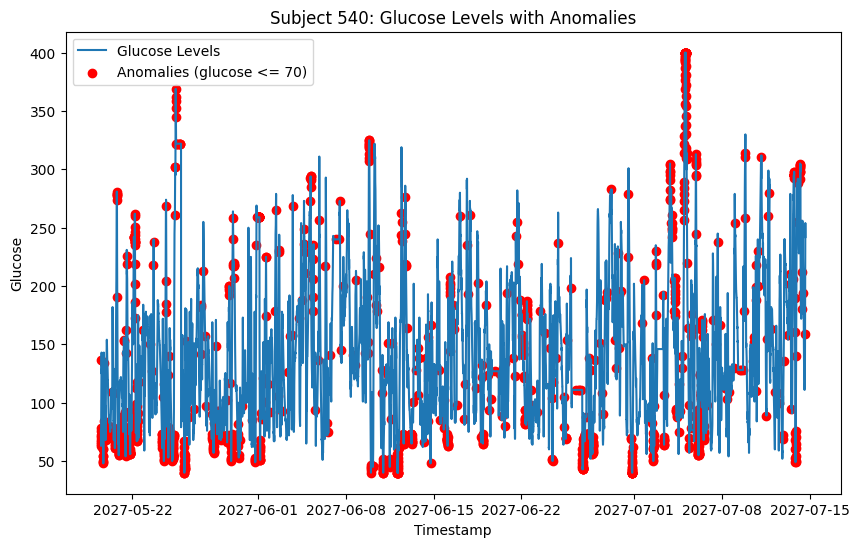

Precision: 0.381
Recall: 0.492
F1 Score: 0.429
ROC-AUC Score: 0.720
Silhouette Score: 0.231


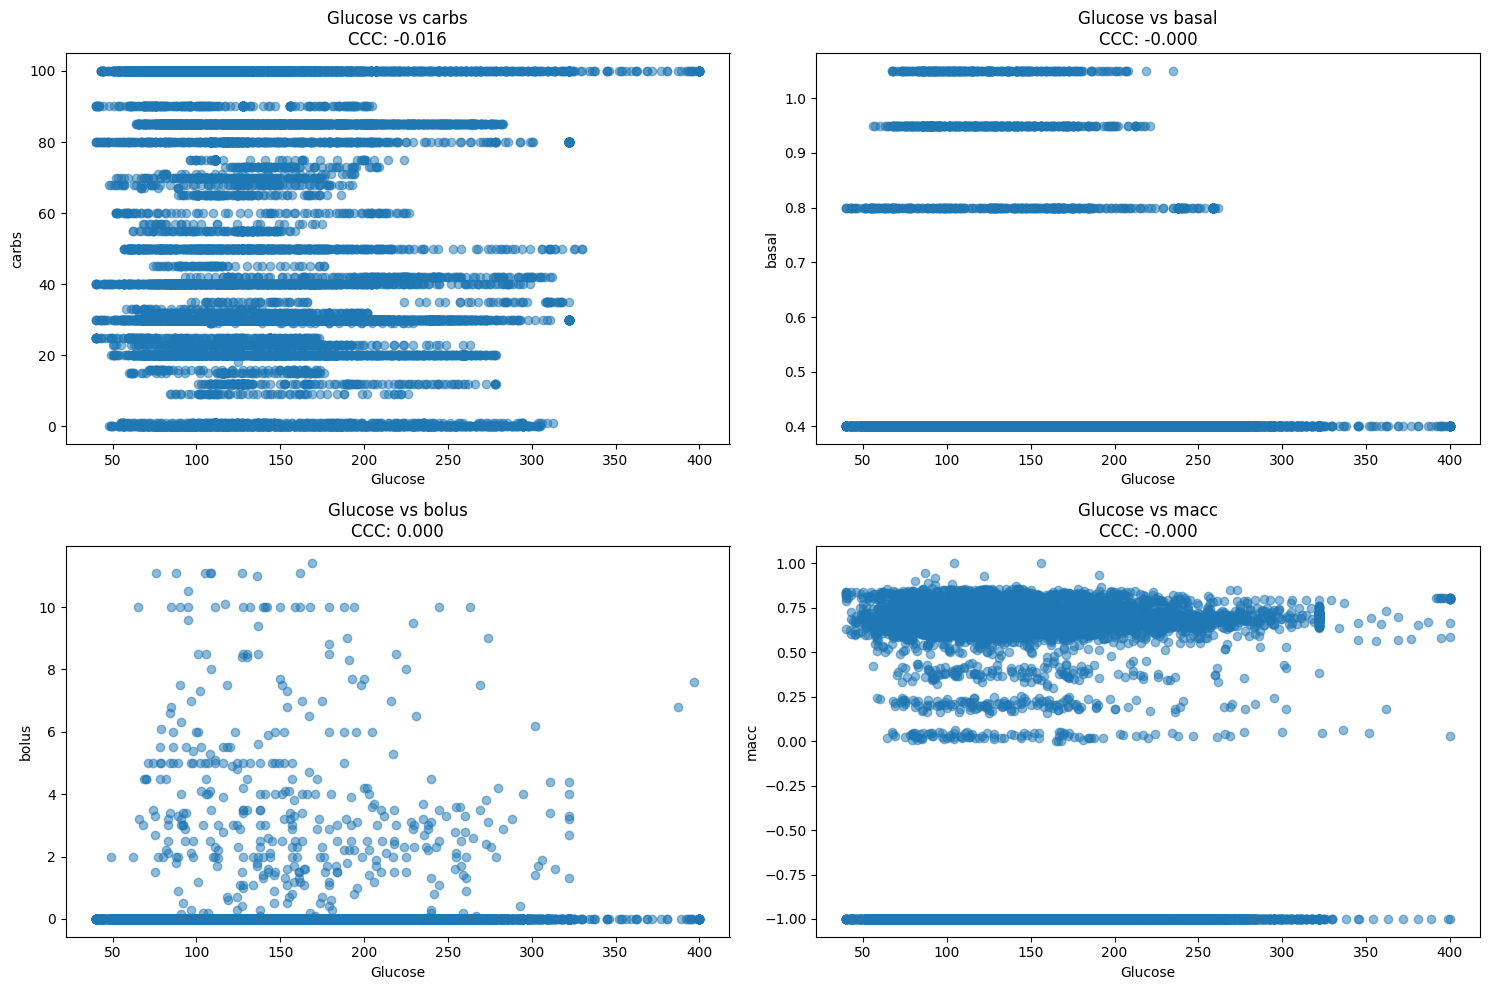

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 808, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 808, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/usr/local/lib/python3.10/

Best parameters: {'gamma': 'scale', 'kernel': 'rbf', 'nu': 0.01}
Best cross-validation accuracy: nan
Processing subject 544
Train file for subject 544: /content/drive/MyDrive/OhioT1DM/OhioT1DM/2020/train/544-ws-training.xml
Test file for subject 544: /content/drive/MyDrive/OhioT1DM/OhioT1DM/2020/test/544-ws-testing.xml
Loading data for subject 544...
Train file path: /content/drive/MyDrive/OhioT1DM/OhioT1DM/2020/train/544-ws-training.xml
Test file path: /content/drive/MyDrive/OhioT1DM/OhioT1DM/2020/test/544-ws-testing.xml


<ipython-input-5-f35b0291da29>:45: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  combined_df['basal'] = combined_df['basal'].fillna(method='ffill').fillna(method='bfill')
<ipython-input-22-e7860ce1a2a0>:65: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  combined_df = combined_df.fillna(method='ffill').fillna(method='bfill')
<ipython-input-14-5a32394eb0f0>:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_local = df_local.fillna(method='ffill').fillna(method='bfill')


Successfully loaded and combined data for subject 544
Number of normal glucose values (>= 70): 15617
Subject has 15808 data points, anomalies predicted: 842


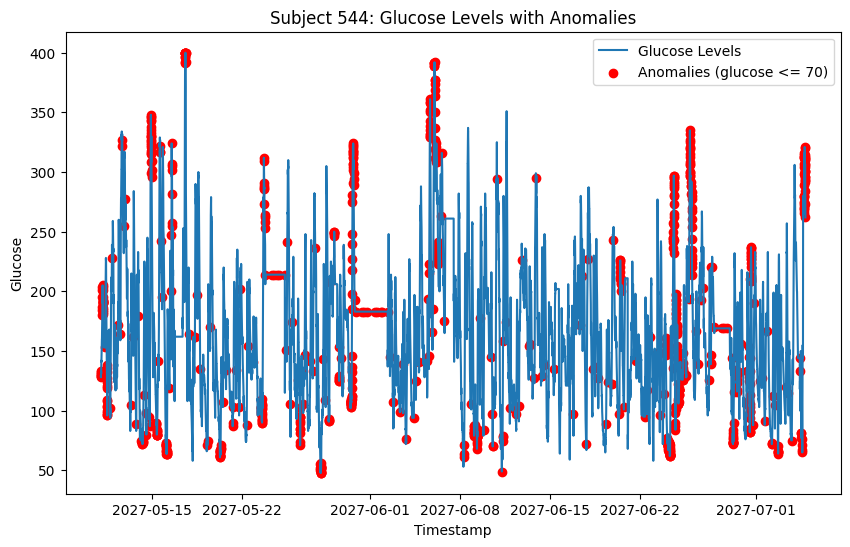

Precision: 0.099
Recall: 0.435
F1 Score: 0.161
ROC-AUC Score: 0.693
Silhouette Score: 0.288


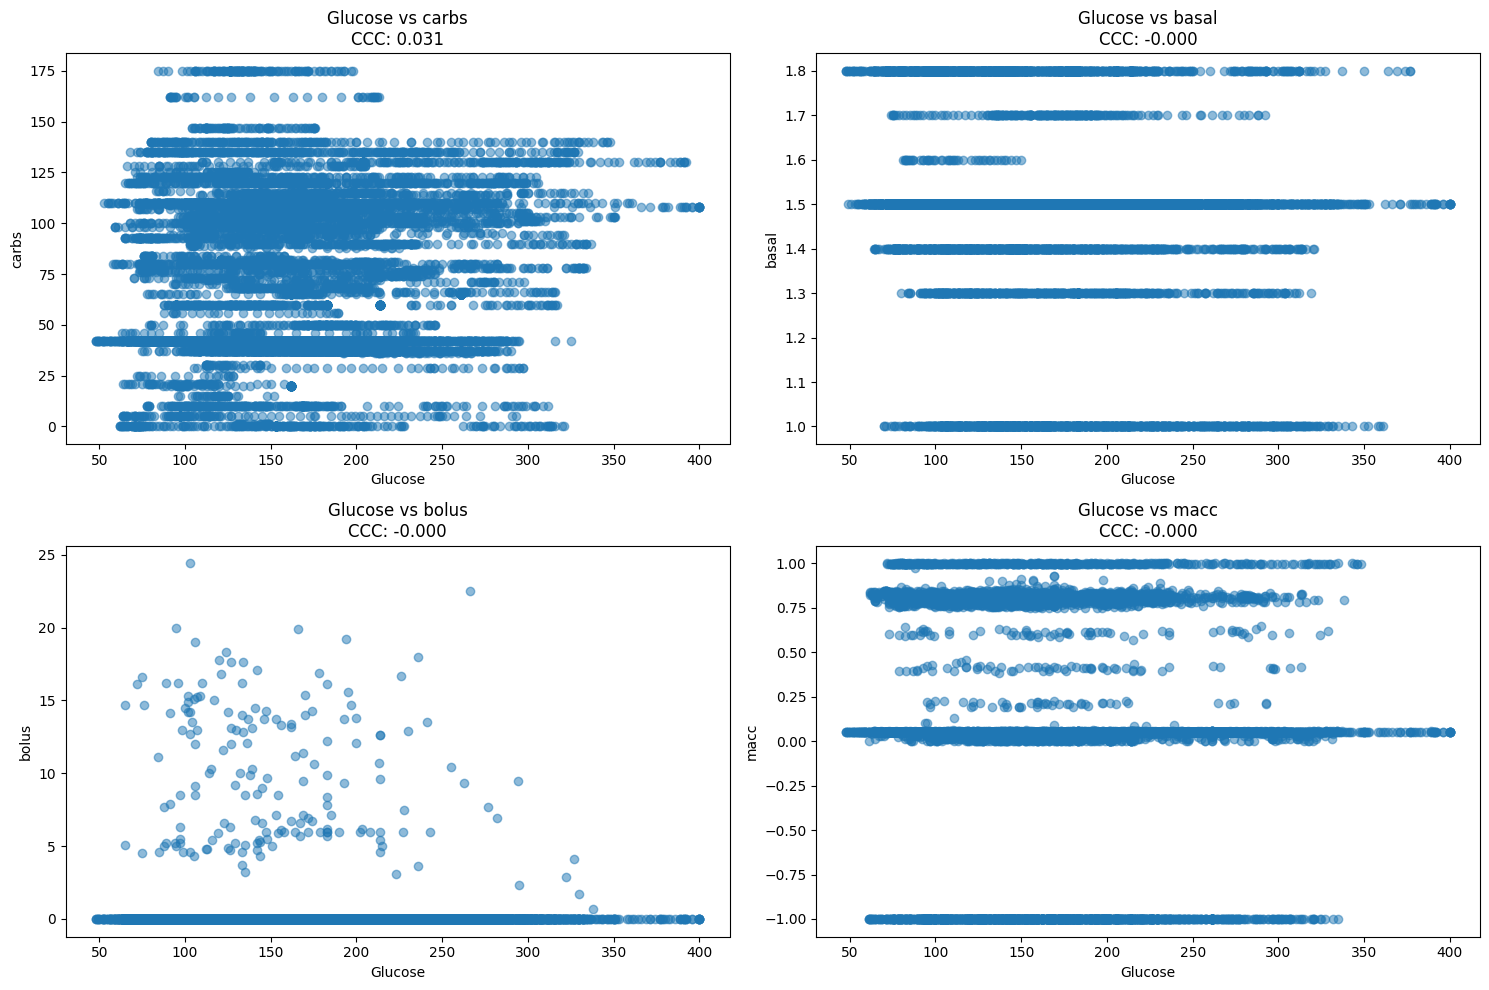

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 808, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 808, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/usr/local/lib/python3.10/

Best parameters: {'gamma': 'scale', 'kernel': 'rbf', 'nu': 0.01}
Best cross-validation accuracy: nan
Processing subject 552
Train file for subject 552: /content/drive/MyDrive/OhioT1DM/OhioT1DM/2020/train/552-ws-training.xml
Test file for subject 552: /content/drive/MyDrive/OhioT1DM/OhioT1DM/2020/test/552-ws-testing.xml
Loading data for subject 552...
Train file path: /content/drive/MyDrive/OhioT1DM/OhioT1DM/2020/train/552-ws-training.xml
Test file path: /content/drive/MyDrive/OhioT1DM/OhioT1DM/2020/test/552-ws-testing.xml


<ipython-input-5-f35b0291da29>:45: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  combined_df['basal'] = combined_df['basal'].fillna(method='ffill').fillna(method='bfill')
<ipython-input-22-e7860ce1a2a0>:65: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  combined_df = combined_df.fillna(method='ffill').fillna(method='bfill')
<ipython-input-14-5a32394eb0f0>:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_local = df_local.fillna(method='ffill').fillna(method='bfill')


Successfully loaded and combined data for subject 552
Number of normal glucose values (>= 70): 14194
Subject has 15048 data points, anomalies predicted: 1213


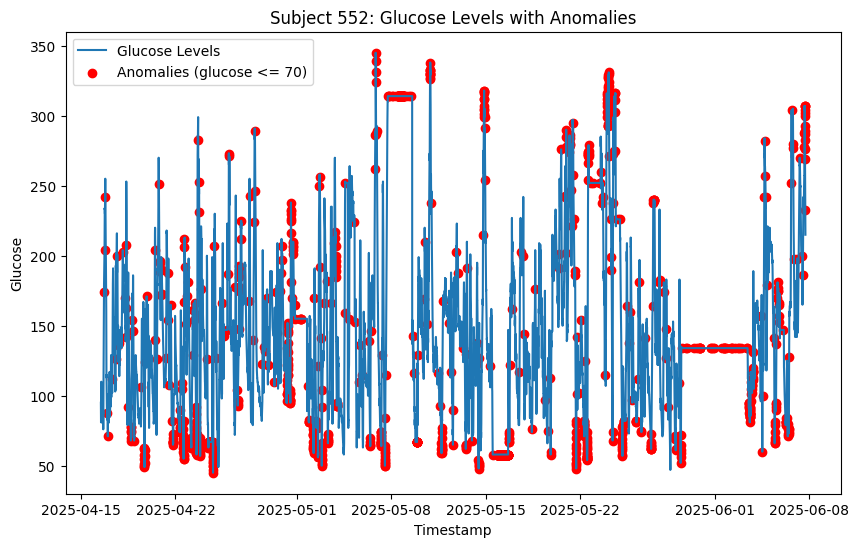

Precision: 0.431
Recall: 0.612
F1 Score: 0.506
ROC-AUC Score: 0.782
Silhouette Score: 0.232


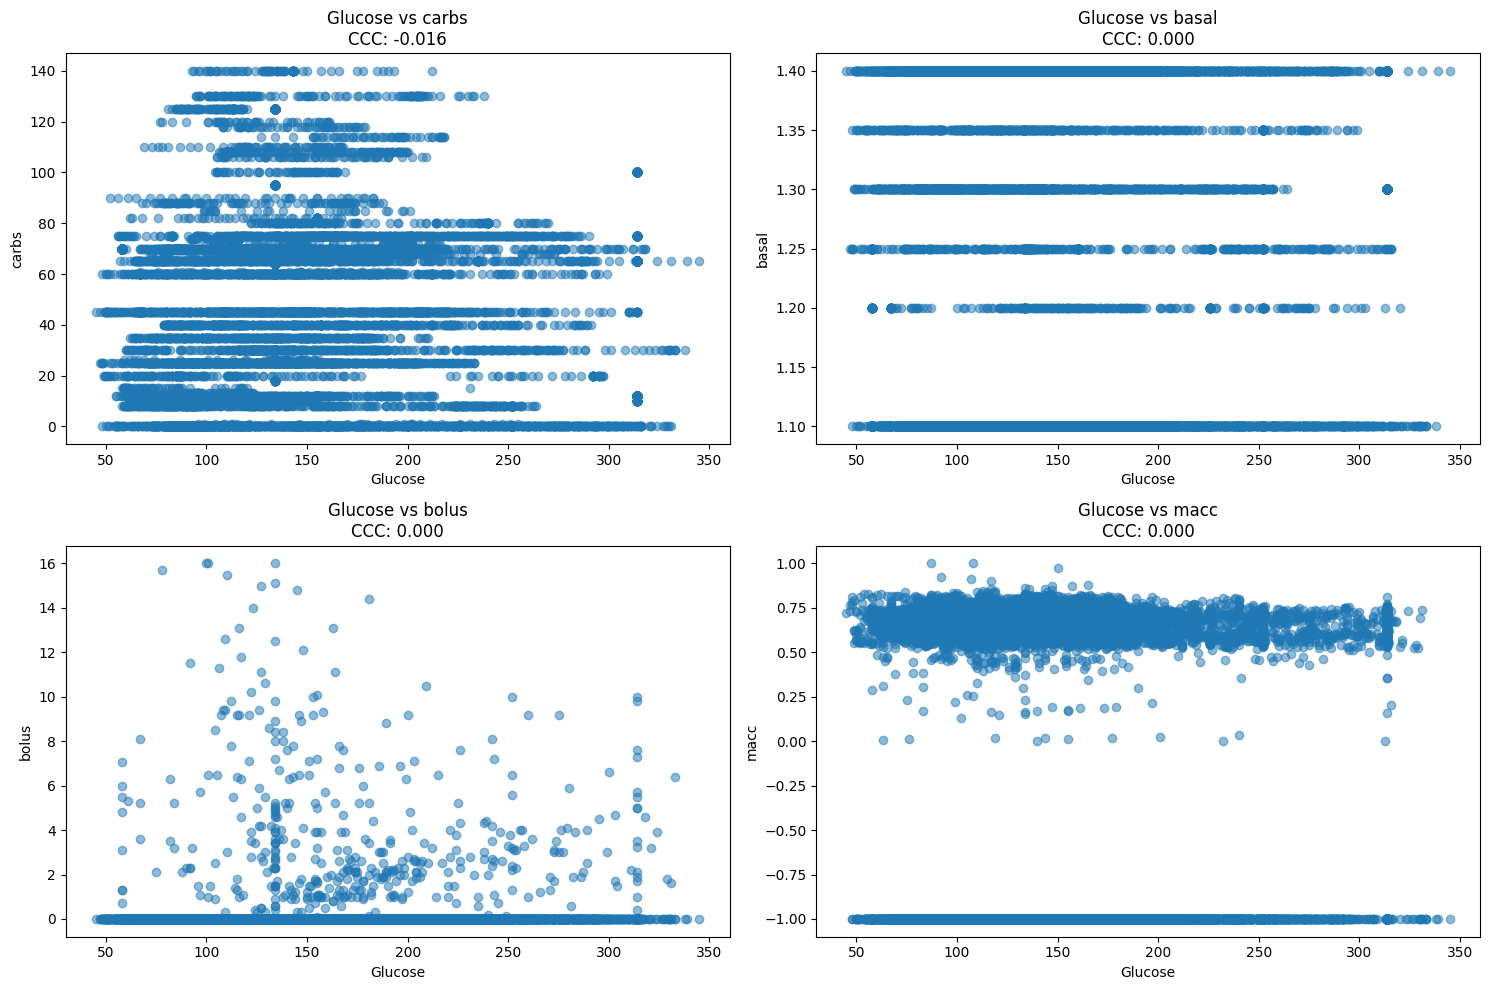

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 808, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 808, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/usr/local/lib/python3.10/

Best parameters: {'gamma': 'scale', 'kernel': 'rbf', 'nu': 0.01}
Best cross-validation accuracy: nan
Processing subject 567
Train file for subject 567: /content/drive/MyDrive/OhioT1DM/OhioT1DM/2020/train/567-ws-training.xml
Test file for subject 567: /content/drive/MyDrive/OhioT1DM/OhioT1DM/2020/test/567-ws-testing.xml
Loading data for subject 567...
Train file path: /content/drive/MyDrive/OhioT1DM/OhioT1DM/2020/train/567-ws-training.xml
Test file path: /content/drive/MyDrive/OhioT1DM/OhioT1DM/2020/test/567-ws-testing.xml
An unexpected error occurred while loading data for subject 567: cannot insert ts, already exists
Skipping subject 567 due to data loading issues.
Processing subject 584
Train file for subject 584: /content/drive/MyDrive/OhioT1DM/OhioT1DM/2020/train/584-ws-training.xml
Test file for subject 584: /content/drive/MyDrive/OhioT1DM/OhioT1DM/2020/test/584-ws-testing.xml
Loading data for subject 584...
Train file path: /content/drive/MyDrive/OhioT1DM/OhioT1DM/2020/train/584-

<ipython-input-5-f35b0291da29>:45: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  combined_df['basal'] = combined_df['basal'].fillna(method='ffill').fillna(method='bfill')
<ipython-input-22-e7860ce1a2a0>:65: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  combined_df = combined_df.fillna(method='ffill').fillna(method='bfill')
<ipython-input-14-5a32394eb0f0>:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_local = df_local.fillna(method='ffill').fillna(method='bfill')


Successfully loaded and combined data for subject 584
Number of normal glucose values (>= 70): 16039
Subject has 16254 data points, anomalies predicted: 1007


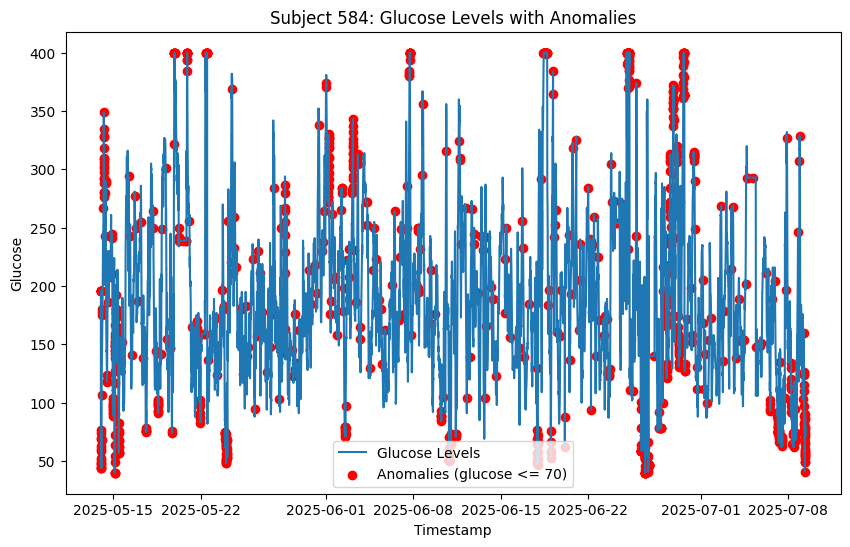

Precision: 0.208
Recall: 0.972
F1 Score: 0.342
ROC-AUC Score: 0.961
Silhouette Score: 0.350


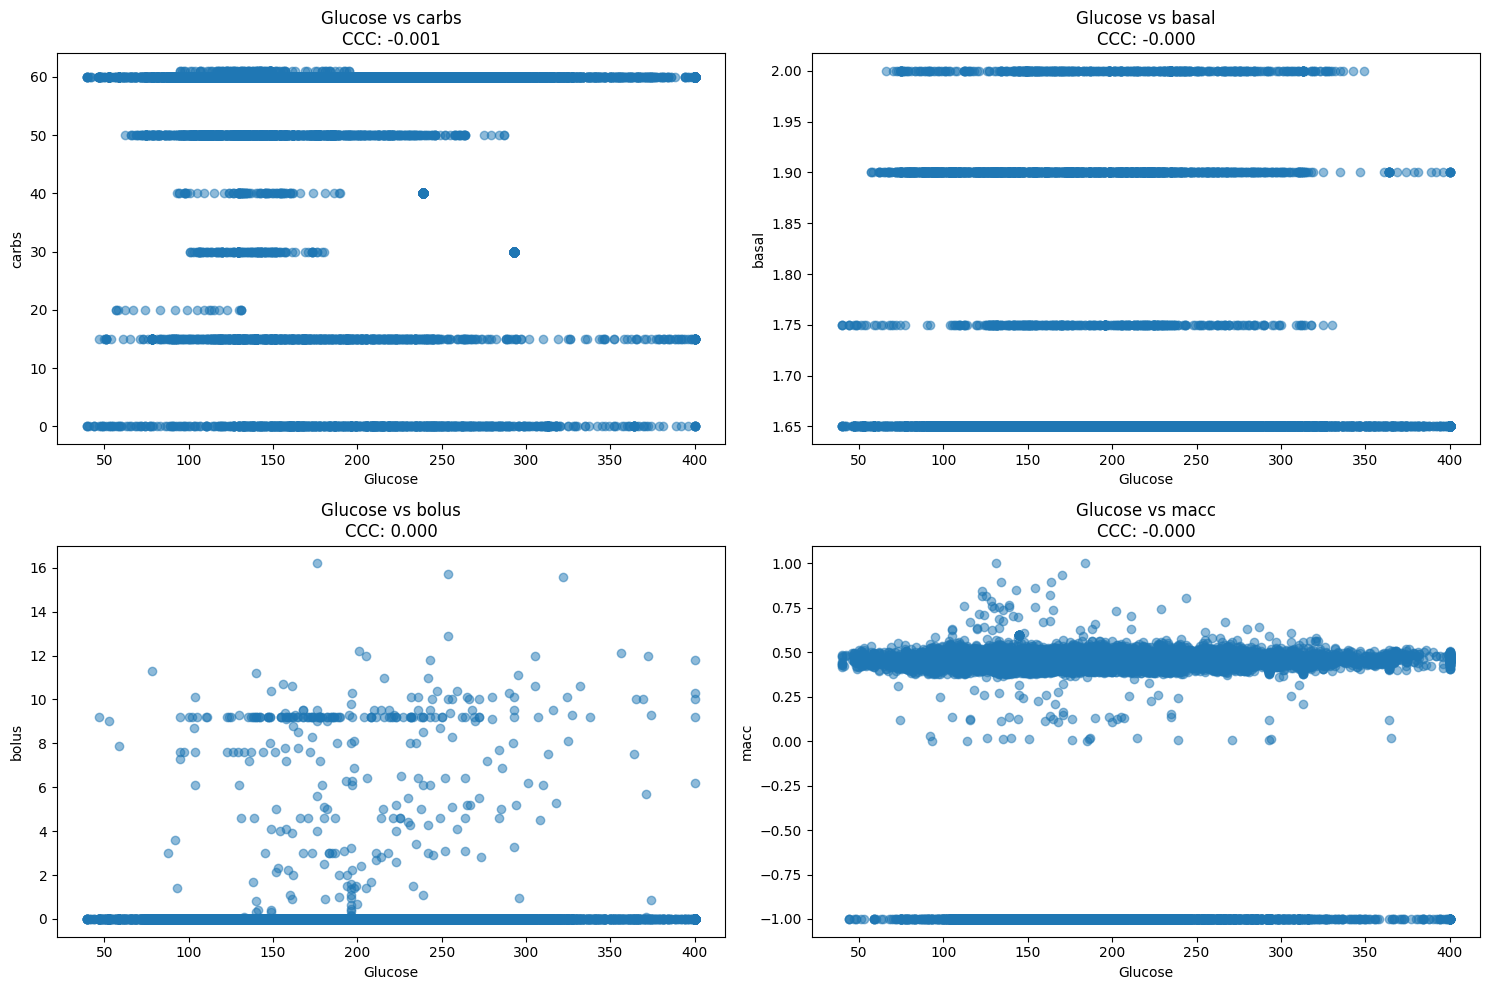

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 808, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 808, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/usr/local/lib/python3.10/

Best parameters: {'gamma': 'scale', 'kernel': 'rbf', 'nu': 0.01}
Best cross-validation accuracy: nan
Processing subject 596
Train file for subject 596: /content/drive/MyDrive/OhioT1DM/OhioT1DM/2020/train/596-ws-training.xml
Test file for subject 596: /content/drive/MyDrive/OhioT1DM/OhioT1DM/2020/test/596-ws-testing.xml
Loading data for subject 596...
Train file path: /content/drive/MyDrive/OhioT1DM/OhioT1DM/2020/train/596-ws-training.xml
Test file path: /content/drive/MyDrive/OhioT1DM/OhioT1DM/2020/test/596-ws-testing.xml


<ipython-input-5-f35b0291da29>:45: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  combined_df['basal'] = combined_df['basal'].fillna(method='ffill').fillna(method='bfill')
<ipython-input-22-e7860ce1a2a0>:65: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  combined_df = combined_df.fillna(method='ffill').fillna(method='bfill')
<ipython-input-14-5a32394eb0f0>:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_local = df_local.fillna(method='ffill').fillna(method='bfill')


Successfully loaded and combined data for subject 596
Number of normal glucose values (>= 70): 16215
Subject has 16632 data points, anomalies predicted: 1087


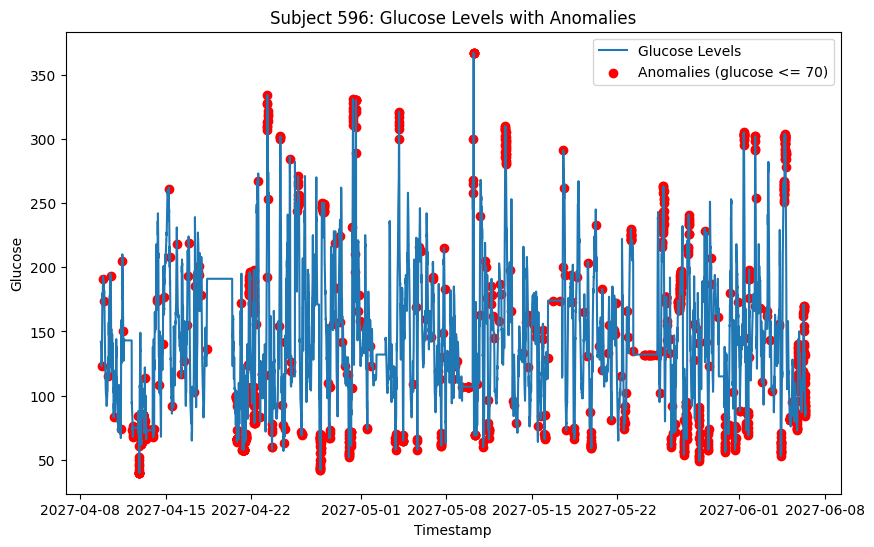

Precision: 0.263
Recall: 0.686
F1 Score: 0.380
ROC-AUC Score: 0.818
Silhouette Score: 0.306


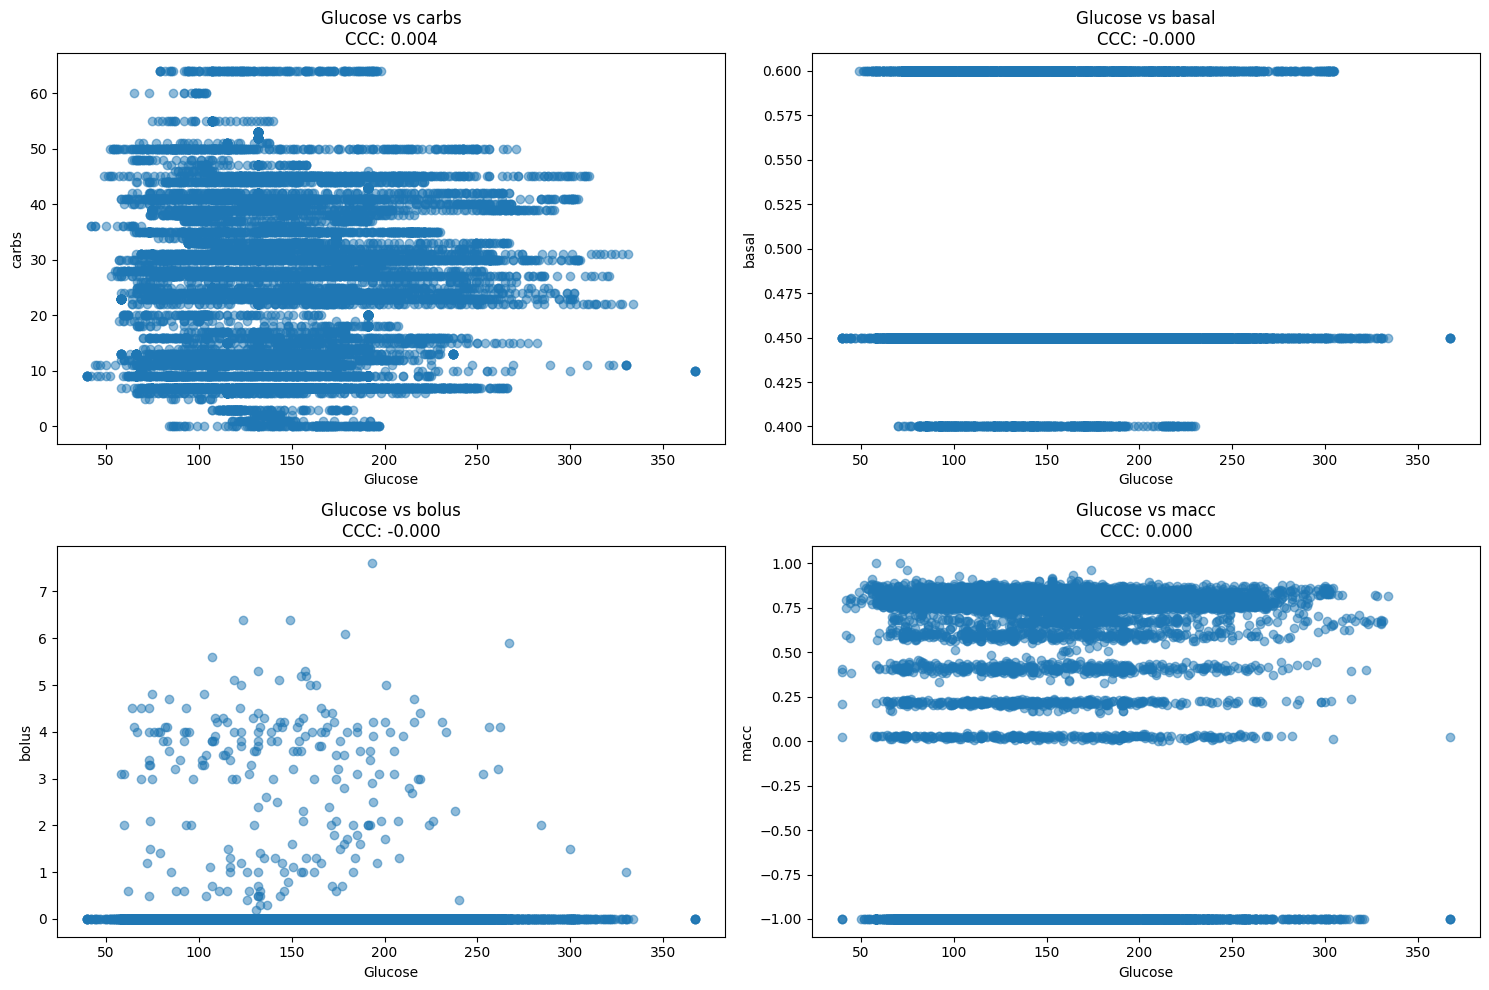

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 808, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 808, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/usr/local/lib/python3.10/

Best parameters: {'gamma': 'scale', 'kernel': 'rbf', 'nu': 0.01}
Best cross-validation accuracy: nan


In [22]:
import os

def main():
    versions_arr = [2018, 2020]

    for v in versions_arr:
        if v == 2018:
            patient_index = [559, 563, 570, 575, 588, 591]
            train_files = [
                '/content/drive/MyDrive/OhioT1DM/OhioT1DM/2018/train/559-ws-training.xml',
                '/content/drive/MyDrive/OhioT1DM/OhioT1DM/2018/train/563-ws-training.xml',
                '/content/drive/MyDrive/OhioT1DM/OhioT1DM/2018/train/570-ws-training.xml',
                '/content/drive/MyDrive/OhioT1DM/OhioT1DM/2018/train/575-ws-training.xml',
                '/content/drive/MyDrive/OhioT1DM/OhioT1DM/2018/train/588-ws-training.xml',
                '/content/drive/MyDrive/OhioT1DM/OhioT1DM/2018/train/591-ws-training.xml'
            ]
            test_files = [
                '/content/drive/MyDrive/OhioT1DM/OhioT1DM/2018/test/559-ws-testing.xml',
                '/content/drive/MyDrive/OhioT1DM/OhioT1DM/2018/test/563-ws-testing.xml',
                '/content/drive/MyDrive/OhioT1DM/OhioT1DM/2018/test/570-ws-testing.xml',
                '/content/drive/MyDrive/OhioT1DM/OhioT1DM/2018/test/575-ws-testing.xml',
                '/content/drive/MyDrive/OhioT1DM/OhioT1DM/2018/test/588-ws-testing.xml',
                '/content/drive/MyDrive/OhioT1DM/OhioT1DM/2018/test/591-ws-testing.xml'
            ]
        elif v == 2020:
            patient_index = [540, 544, 552, 567, 584, 596]
            train_files = [
                '/content/drive/MyDrive/OhioT1DM/OhioT1DM/2020/train/540-ws-training.xml',
                '/content/drive/MyDrive/OhioT1DM/OhioT1DM/2020/train/544-ws-training.xml',
                '/content/drive/MyDrive/OhioT1DM/OhioT1DM/2020/train/552-ws-training.xml',
                '/content/drive/MyDrive/OhioT1DM/OhioT1DM/2020/train/567-ws-training.xml',
                '/content/drive/MyDrive/OhioT1DM/OhioT1DM/2020/train/584-ws-training.xml',
                '/content/drive/MyDrive/OhioT1DM/OhioT1DM/2020/train/596-ws-training.xml'
            ]
            test_files = [
                '/content/drive/MyDrive/OhioT1DM/OhioT1DM/2020/test/540-ws-testing.xml',
                '/content/drive/MyDrive/OhioT1DM/OhioT1DM/2020/test/544-ws-testing.xml',
                '/content/drive/MyDrive/OhioT1DM/OhioT1DM/2020/test/552-ws-testing.xml',
                '/content/drive/MyDrive/OhioT1DM/OhioT1DM/2020/test/567-ws-testing.xml',
                '/content/drive/MyDrive/OhioT1DM/OhioT1DM/2020/test/584-ws-testing.xml',
                '/content/drive/MyDrive/OhioT1DM/OhioT1DM/2020/test/596-ws-testing.xml'
            ]

# Process each subject
        for idx, subject_id in enumerate(patient_index):
            print(f"Processing subject {subject_id}")

            # Ensure that the train and test files are valid XML files
            train_file = train_files[idx]
            test_file = test_files[idx]

            # Debugging file paths
            print(f"Train file for subject {subject_id}: {train_file}")
            print(f"Test file for subject {subject_id}: {test_file}")

            # Load data for the current subject
            combined_df = load_data(train_file, test_file, subject_id, version=v)

            if combined_df is None:
                print(f"Skipping subject {subject_id} due to data loading issues.")
                continue

            # --- Step 1: Data Preprocessing ---
            # Check for NaN values and fill them if necessary
            combined_df = combined_df.fillna(method='ffill').fillna(method='bfill')

            # Check for constant values in the features
            for feature in ['carbs', 'basal', 'bolus', 'macc']:
                if combined_df[feature].nunique() == 1:
                    print(f"Feature {feature} has constant values. CCC may return nan.")

            # Apply One-Class SVM
            combined_df = apply_one_class_svm(combined_df)

            # Plot anomalies
            plot_anomalies(combined_df, subject_id)

            # Evaluate the model
            synthetic_labels = create_synthetic_labels(combined_df)
            evaluate_with_labels(combined_df, synthetic_labels)
            evaluate_roc_auc(combined_df, synthetic_labels)
            evaluate_silhouette_score(combined_df)

            # Plot and evaluate CCC for glucose and other features
            plot_ccc_with_features(combined_df)

            # Optional: Hyperparameter tuning (on normal data)
            X_normal = combined_df[combined_df['glucose'] > 70][['glucose', 'carbs', 'basal', 'bolus', 'macc']].fillna(0)
            tune_one_class_svm(X_normal)

if __name__ == '__main__':
    main()